# Setup

In [1]:

# import libraries

# basics
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from imblearn.over_sampling import SMOTE
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# basics for models
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# principal component analysis
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

# k-means
from sklearn.cluster import KMeans

# knn
from sklearn.neighbors import KNeighborsClassifier

# logistic regression
from sklearn.linear_model import LogisticRegression

# support vector machine
from sklearn.svm import SVC

# decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# random forest
from sklearn.ensemble import RandomForestClassifier

# feedforward neural network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import metrics

2023-12-11 14:37:48.946862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# set display settings

warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.set_option("display.max_rows", None)
pd.set_option('display.max_columns', None)

# Import Tabular Data and Define Column Groups

In [3]:
# specify columns and datatypes, load full consolidated sdss dataset, and create class map

# load column names from file into a list
sdss_headers = pd.read_csv('../data/processed/sdss_full.csv.gz', compression='gzip', header=0, index_col=0, nrows=0).columns.tolist()

# specify column groups
object_identifiers = ['dr8objid']
galaxy_identifiers = ['gz2_filenumber']
object_locations = ['ra', 'dec']
class_label_names = ['sdss_clean_class_name', 'stellar_subclass_MK', 'gz2_subclass_hubble']
class_label_codes = ['sdss_clean_class_code', 'stellar_subclass_code', 'gz2_subclass_code']
galaxy_binary_labels = [label for label in sdss_headers if 'flag' in label]
galaxy_filters = ['petroR90_r_log']
object_features = ['redshift_log', 'sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
star_features = ['elodie_color_index', 'elodie_temperature', 'elodie_metallicity']
# consider adding galaxy features:  ratio of petro_radius to petro_brightness

# create a datatype dictionary for object_identifiers
col_dtypes = {col: 'string' for col in object_identifiers + galaxy_identifiers}

# load full consolidated sdss dataset
sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)

# create map between class label codes and class label names
sdss_clean_class_map = dict(zip(sdss_primary[class_label_names[0]], sdss_primary[class_label_codes[0]]))
stellar_subclass_map = dict(zip(sdss_primary[class_label_names[1]], sdss_primary[class_label_codes[1]]))
gz2_subclass_map = dict(zip(sdss_primary[class_label_names[2]], sdss_primary[class_label_codes[2]]))
class_code_maps = [sdss_clean_class_map, stellar_subclass_map, gz2_subclass_map]

/tmp/ipykernel_22164/1582399338.py:22: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49) have mixed types. Specify dtype option on import or set low_memory=False.
  sdss_primary = pd.read_csv('../data/processed/sdss_primary.csv.gz', compression='gzip', header=0, dtype=col_dtypes)


# EDA - Investigate Classes and Features in Tabular Data

### Define and Call Helper Functions

In [4]:
# inspect the imported data

""" # display some data
display(sdss_primary.head(3))
display(sdss_primary.tail(3))
display(sdss_primary.sample(10))"""
 
# inspect dataframe
"""print(sdss_primary.shape)
print(sdss_primary.info())"""

'print(sdss_primary.shape)\nprint(sdss_primary.info())'

In [5]:
"""# investigate superclasses & simplified subclasses (categorical label names)

# create a helper function for investigating and plotting a subset from a column w/ categorical data
def investigate_clean_classes(df, column, filter=None):
    data = df[column]
    if filter:
        data = df[df['sdss_clean_class_name'] == filter][column]
    unclassified_count = data.isna().sum() + (data == 'unclassified').sum() + (data == 'unkonwn').sum()
    print(f"\n---------- {column} : {filter} ----------")
    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")
    print(f"The number of unique labels is: {len(df[column].unique())}")
    data2 = data[data != 'unclassified']
    data2 = data2[data2 != 'unknown']
    plt.figure(figsize=(3, 2))
    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette='viridis')
    #plt.suptitle(f"{column = }")
    #plt.tight_layout()
    plt.show()

investigate_clean_classes(sdss_primary, 'sdss_clean_class_name')
investigate_clean_classes(sdss_primary, 'gz2_subclass_hubble', 'galaxy')
investigate_clean_classes(sdss_primary, 'stellar_subclass_MK', 'star')"""

'# investigate superclasses & simplified subclasses (categorical label names)\n\n# create a helper function for investigating and plotting a subset from a column w/ categorical data\ndef investigate_clean_classes(df, column, filter=None):\n    data = df[column]\n    if filter:\n        data = df[df[\'sdss_clean_class_name\'] == filter][column]\n    unclassified_count = data.isna().sum() + (data == \'unclassified\').sum() + (data == \'unkonwn\').sum()\n    print(f"\n---------- {column} : {filter} ----------")\n    print(f"The number of rows with classified values is: {len(data) - unclassified_count}")\n    print(f"The number of unique labels is: {len(df[column].unique())}")\n    data2 = data[data != \'unclassified\']\n    data2 = data2[data2 != \'unknown\']\n    plt.figure(figsize=(3, 2))\n    sns.countplot(y=data2, order=data2.value_counts().index[:15], palette=\'viridis\')\n    #plt.suptitle(f"{column = }")\n    #plt.tight_layout()\n    plt.show()\n\ninvestigate_clean_classes(sdss_pri

In [6]:
"""# investigate histograms of feature columns, color-shaded by superclass

# generate a subset dataframe
df = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]
df = df.sample(frac=0.5)

# define classes
classes = sdss_primary['sdss_clean_class_name'].unique()

# set a color palette with distinct colors for each category
colors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))

# iterate over columns and create separate plots
for col in object_features + star_features:
    plt.figure(figsize=(3, 2))
    plt.xscale('linear')
    log_choice = False
    denom = df[col].min()
    if denom == 0:
        denom = 0.001
    if abs(df[col].max() / denom) > 50:
        df[col] = df[col].replace(0, 0.001)
        log_choice = True
        plt.xscale('symlog')  
    for class_label, color in zip(classes, colors):
        if 'elodie' in col:
            if class_label == 'star':
                sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
        else:
            sns.histplot(df[df['sdss_clean_class_name'] == class_label][col], bins=25, label=class_label, log_scale=log_choice)
    plt.title(col)
    plt.legend()
    plt.show()"""

"# investigate histograms of feature columns, color-shaded by superclass\n\n# generate a subset dataframe\ndf = sdss_primary[['sdss_clean_class_name'] + object_features + star_features]\ndf = df.sample(frac=0.5)\n\n# define classes\nclasses = sdss_primary['sdss_clean_class_name'].unique()\n\n# set a color palette with distinct colors for each category\ncolors = sns.color_palette('bright', n_colors=len(df['sdss_clean_class_name'].unique()))\n\n# iterate over columns and create separate plots\nfor col in object_features + star_features:\n    plt.figure(figsize=(3, 2))\n    plt.xscale('linear')\n    log_choice = False\n    denom = df[col].min()\n    if denom == 0:\n        denom = 0.001\n    if abs(df[col].max() / denom) > 50:\n        df[col] = df[col].replace(0, 0.001)\n        log_choice = True\n        plt.xscale('symlog')  \n    for class_label, color in zip(classes, colors):\n        if 'elodie' in col:\n            if class_label == 'star':\n                sns.histplot(df[df['sdss

# Define Helper Functions for Tabular Data

In [7]:
# define a helper function to extract only objects of interest, given a specified set of classes

def jsm_specify_objects(objects='superclass', min_set_size=1000):
    
    # return secondary dataset containing only defined objects
    if objects == 'superclass':
        class_code_column = class_label_codes[0:1] #'sdss_clean_class_code'
        class_name_column  = class_label_names[0]
    elif objects == 'stars':
        class_code_column = class_label_codes[1:2] #'stellar_subclass_MK'
        class_name_column  = class_label_names[1]
    elif objects == 'galaxies':
        class_code_column = class_label_codes[2:3] #'gz2_subclass_hubble'
        class_name_column  = class_label_names[2]
    
    # drop rows corresponding to unclassified objects
    sdss_secondary = sdss_primary[sdss_primary[class_name_column] != 'unclassified']
        
    # drop rows corresponding to label that fall below the minimum set size for each label
    label_counts = sdss_secondary[class_name_column].value_counts()
    labels_to_drop = label_counts[label_counts < min_set_size].index
    sdss_secondary = sdss_secondary[~sdss_secondary[class_name_column].isin(labels_to_drop)]
    
    # replace the code values with a sequence of integers
    sdss_secondary[class_code_column[0]] = pd.factorize(sdss_secondary[class_code_column[0]])[0]

    # define label codes and names as well as a mapping dictionary
    df_unique = sdss_secondary[[class_code_column[0], class_name_column]].drop_duplicates()
    df_unique = df_unique.sort_values(by=class_code_column[0])
    label_map = dict(zip(df_unique[class_code_column[0]], df_unique[class_name_column]))
    label_codes = list(label_map.keys())
    label_names = list(label_map.values())
    
    return class_code_column, sdss_secondary, label_map, label_codes, label_names

In [8]:
# define a helper function to facilitate rebalancing -- shuffle only ('none'), sample equal numbers of least-common label ('equal'), or apply SMOTE ('smote')

def jsm_rebalance(X, y, class_column, mode='none'):
    
    indices = X.index.tolist()
    random.shuffle(indices)
    X_resampled = X.loc[indices]
    y_resampled = y.loc[indices]
    
    if mode == 'rarest':
        grouped_df = X_resampled.groupby(y_resampled[class_column[0]], group_keys=False)
        X_resampled = grouped_df.apply(lambda x: x.sample(min(len(x), y_resampled[class_column].value_counts().min())))
        y_resampled = y_resampled.loc[X_resampled.index]
        X_resampled = X_resampled.reset_index(drop=True)
        y_resampled = y_resampled.reset_index(drop=True)
    elif mode == 'smote':
        smote = SMOTE()
        X_resampled, y_resampled = smote.fit_resample(X_resampled, y_resampled)
    
    return X_resampled, y_resampled

In [9]:
# define a helper function to split into subsets using either np/pd or sklearn

def jsm_split_subsets(df, feature_cols, label_cols, ratios, mode='default', seed=38):
    
    np.random.seed(seed)
    train_ratio = ratios[0]
    validation_ratio = ratios[1]
    test_ratio = ratios[2]
    
    if mode == 'default':
        num_rows = df.shape[0]
        indices = np.random.permutation(num_rows)
        train_end = int(train_ratio * num_rows)
        validation_end = int((train_ratio + validation_ratio) * num_rows)
        train_indices = indices[:train_end]
        validation_indices = indices[train_end:validation_end]
        test_indices = indices[validation_end:]
        train_set = df.iloc[train_indices]
        validation_set = df.iloc[validation_indices]
        test_set = df.iloc[test_indices]
    elif mode == 'sklearn':
        train_set, temp_set = train_test_split(df, test_size=(1 - train_ratio))
        validation_set, test_set = train_test_split(temp_set, test_size=test_ratio/(validation_ratio + test_ratio))
    
    X_train = train_set[feature_cols]
    y_train = train_set[label_cols]
    X_validation = validation_set[feature_cols]
    y_validation = validation_set[label_cols]
    X_test = test_set[feature_cols]
    y_test = test_set[label_cols]
    
    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [10]:
# define a helper function perform PCA on a given data subset and visualize train results (esp. feature importance)

def pca_features(X, features):
    
    # fit the object_identifiers to a PCA model
    pca = PCA().fit(X)
    #print(type(pca))

    # evaluate the PCA loadings
    loadings = pd.DataFrame(
        data=pca.components_.T * np.sqrt(pca.explained_variance_ratio_), 
        columns=[f'PC{i}' for i in range(1, len(features) + 1)],
        index=features
    )
    loadings.head()
    
    # display some data
    """print(loadings.shape)
    display(loadings.head(5))"""
    
    # plot the cumulative variance by # of principal components
    # NOTE: the first PC already explaines ~80% of the total variance in the dataset
    plt.figure(figsize=(3,2))
    plt.plot(pca.explained_variance_ratio_.cumsum())
    plt.title('Cumulative % variation explained by principal components)', size=12)
    plt.show()

    # visualize correlations between first PC and object_features
    pc1_loadings = loadings.sort_values(by='PC1', ascending=False)[['PC1']]
    pc1_loadings = pc1_loadings.reset_index()
    pc1_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc1_loadings['Attribute'], height=pc1_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (first principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()

    # visualize correlations between second PC and object_features
    pc2_loadings = loadings.sort_values(by='PC2', ascending=False)[['PC2']]
    pc2_loadings = pc2_loadings.reset_index()
    pc2_loadings.columns = ['Attribute', 'CorrelationWithPC1']
    plt.figure(figsize=(3,2))
    plt.bar(x=pc2_loadings['Attribute'], height=pc2_loadings['CorrelationWithPC1'], color='#087E8B')
    plt.title('PCA loading scores (second principal component)', size=12)
    plt.xticks(rotation='vertical')
    plt.show()
    
    return loadings

In [11]:
# define a helper function to create pandas dataframe for visualizing the model in scatter and tabular formats: X7_train (ndarray) --> pca_examples_table (df)

def pca_examples(X_ndarray, y_df, class_column, class_map):    
    
    # convert ndarray to pd df of first 3 PC's
    temp1 = pd.DataFrame(data=X_ndarray, columns=['PC1','PC2','PC3'])
    temp1.reset_index(drop=True, inplace=True)

    # add labeled rows to df
    temp2 = y_df[class_column]
    temp2.reset_index(drop=True, inplace=True)
    
    # generate df of examples transformed to first 3 PC's, along with associated labels
    pca_df = pd.concat([temp1, temp2], axis=1)
    
    # exchange the map keys/values and derive column for class name
    flipped_map = {value: key for key ,value in class_map.items()}
    pca_df['class_name'] = pca_df[class_column[0]].map(flipped_map)
                                                
    # resample the pca dataframe
    pca_df_subset = pca_df.sample(frac=0.05)

    # display some data
    """print(pca_df.shape)
    display(pca_df.head(5))"""
    
    # generate a scatterplot from a subset of the df along the first two PC's
    plt.figure(figsize=(5,4))
    for class_code in pca_df_subset[class_column[0]].unique():
        label_name = label_map[class_code]
        class_data = pca_df_subset[pca_df_subset[class_column[0]] == class_code]
        plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {label_name}', cmap='viridis', s=1, alpha=0.5)
        plt.title('Scatter along principal components')
    plt.title('Scatter along first two principal components')
    plt.legend()
    plt.show()

    # generate a 3d scatterplot of the first three PC's from the df
    fig = plt.figure().add_subplot(projection='3d')
    for class_code in pca_df_subset[class_column[0]].unique():
        label_name = label_map[class_code]
        class_data = pca_df_subset[pca_df_subset[class_column[0]] == class_code]
        fig.scatter(class_data['PC3'], class_data['PC2'], class_data['PC1'], label=f'Class {label_name}', cmap='viridis', s=3, alpha=0.4)
    plt.title('Scatter along first three principal components')
    plt.legend()
    plt.show()
    
    return pca_df

In [12]:
# define a function to make an elbow plot for number of k-means clusters

def kmeans_elbow(X):

    distortions = []
    for i in range(1,15):
        km = KMeans(
        n_clusters=i,
        init='k-means++',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=38
        )
        km.fit(X)
        distortions.append(km.inertia_)

    plt.plot(range(1,15), distortions, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

In [13]:
# define a helper function to retrieve model names

def return_variable_name(obj):
    
    for k, v in globals().items():
        if v is obj:
            return k

In [14]:
# define a helper function to load existing or save new model

def jsm_fit_model(model, objects, X, y, X0_validation, y_validation, mode='load', epochs=1, batch_size=None, verbose=2):
    
    model_name = return_variable_name(model)
    
    if mode == 'load':
        if any(isinstance(model, cls) for cls in [sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin]):
            model = pickle.load(open(f"../models/model_{objects}_{model_name}.sav", 'rb'))
            history = None
        elif isinstance(model, keras.models.Sequential):
            model = tf.keras.models.load_model(f"../models/model_{objects}_{model_name}.h5")
            history = pickle.load(open(f"../models/model_{objects}_{model_name}_history.sav", 'rb'))
    elif mode == 'save':
        if any(isinstance(model, cls) for cls in [sklearn.base.BaseEstimator, sklearn.base.ClassifierMixin]):
            model = model.fit(X, y)
            history = None
            #pickle.dump(model, open(f"../models/model_{objects}_{model_name}.sav", 'wb'))
        elif isinstance(model, keras.models.Sequential):
            history = model.fit(X, y, validation_data=(X0_validation, y_validation), epochs=epochs, batch_size=batch_size, verbose=verbose)
            #model.save(f"../models/model_{objects}_{model_name}.h5", overwrite=True, include_optimizer=True, save_format='h5')
            #pickle.dump(history.history, open(f"../models/model_{objects}_{model_name}_history.sav", 'wb'))
            history = history.history
    
    """print(f"{type(model) = }")
    print(f"{type(history) = }")"""
    
    return model, history

In [15]:
# define a helper function to make predictions using a model print

def jsm_predict(model, X, y):

    #print(X.shape)
    y_pred = model.predict(X)
    
    if isinstance(model, keras.models.Sequential):
        y_pred = np.argmax(y_pred, axis=-1)
    
    acs = accuracy_score(y, y_pred)
    ps = precision_score(y, y_pred, average='weighted')
    rs = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')
    metric = {"Accuracy Score": round(acs,4), "Precision Score": round(ps,4), "Recall Score": round(rs,4), "F1 Score": round(f1,4)}
    print(metric)
    
    y_label_names = y[class_column[0]].map(label_map).to_frame(name=class_column[0])
    y_pred_label_names = np.vectorize(label_map.get)(y_pred)
    
    class_report = classification_report(y_label_names, y_pred_label_names)
    print(class_report)
    
    #print(type(y))
    #print(type(y_pred))
    
    cm = confusion_matrix(y_label_names, y_pred_label_names)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label_names).plot()
    plt.show()

In [16]:
# define a helper function to plot train/validation performance of keras models

def jsm_plot_history(hist):
    
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
    ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

# Preprocessing Tabular Data

### Specify object set for classification

In [17]:
# specify secondary dataset based on inclusion of all objects ('superclass'), only labeled galaxies ('galaxies'), or only labeled stars ('stars')

objects = 'superclass'

class_column, sdss_secondary, label_map, label_codes, label_names = jsm_specify_objects(objects, min_set_size=1000)
print(f"\n{class_column = }")
display(sdss_secondary.head(5))
print(f"{label_map = }")
print(f"{label_codes = }")
print(f"{label_names = }")

if objects == 'stars':
    features = object_features + star_features
else:
    features = object_features


class_column = ['sdss_clean_class_code']


,dr8objid,gz2_filenumber,ra,dec,sdss_clean_class_name,sdss_clean_class_code,stellar_subclass_MK,stellar_subclass_code,gz2_subclass_hubble,gz2_subclass_code,gz1_flag_spiral,gz1_flag_elliptical,gz1_flag_uncertain,gz2_flag_smooth,gz2_flag_features_or_disk,gz2_flag_star_or_artifact,gz2_flag_edgeon_yes,gz2_flag_edgeon_no,gz2_flag_bar_yes,gz2_flag_bar_no,gz2_flag_spiral_yes,gz2_flag_spiral_no,gz2_flag_bulge_none1,gz2_flag_bulge_small,gz2_flag_bulge_medium,gz2_flag_bulge_large,gz2_flag_odd_yes,gz2_flag_odd_no,gz2_flag_round_circular,gz2_flag_round_medium,gz2_flag_round_cigar,gz2_flag_feature_ring,gz2_flag_feature_lens_or_arc,gz2_flag_feature_disturbed,gz2_flag_feature_irregular,gz2_flag_feature_other,gz2_flag_feature_merger,gz2_flag_feature_dust_lane,gz2_flag_bulge_round,gz2_flag_bulge_boxy,gz2_flag_bulge_none2,gz2_flag_arms_tight,gz2_flag_arms_medium,gz2_flag_arms_loose,gz2_flag_arms_1,gz2_flag_arms_2,gz2_flag_arms_3,gz2_flag_arms_4,gz2_flag_arms_many,gz2_flag_arms_unsure,petroR90_r_log,redshift_log,sum_p,u-r_p,g-i_p,r-z_p,elodie_color_index,elodie_temperature,elodie_metallicity
0,1237651252584448100,192933,236.355530,54.820911,galaxy,0,unclassified,8,SBc,5,True,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,2.263365,-2.299111,85.88830,2.09786,1.09673,0.63014,NaN,NaN,NaN
1,1237651252584448112,<NA>,236.342000,54.802830,galaxy,0,unclassified,8,unclassified,14,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.878837,-1.543686,88.50900,2.39652,1.32288,0.71409,NaN,NaN,NaN
2,1237651252584251555,32264,235.891464,55.133472,galaxy,0,unclassified,8,SBc,5,True,False,False,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.352307,-2.803127,77.52239,2.37586,1.12715,0.67207,NaN,NaN,NaN
3,1237651252584317089,32265,236.063721,55.035847,galaxy,0,unclassified,8,Sc,9,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,2.218923,-2.673609,84.18209,1.77608,0.65633,0.23047,NaN,NaN,NaN
4,1237655130907213985,<NA>,236.150100,54.775720,galaxy,0,unclassified,8,unclassified,14,False,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.288587,-2.440658,89.05857,1.44878,0.69195,0.46791,NaN,NaN,NaN


label_map = {0: 'galaxy', 1: 'star', 2: 'quasar'}
label_codes = [0, 1, 2]
label_names = ['galaxy', 'star', 'quasar']


### Split Data into Train, Validation, and Test Subsets

In [18]:
# generate subsets (return as df's)

X_train, y_train, X_validation, y_validation, X_test, y_test = jsm_split_subsets(sdss_secondary, features, class_column, [0.6, 0.2, 0.2], mode='sklearn')
display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p
176373,-2.210827,82.03548,2.82417,1.31543,0.72571
1051074,-3.873121,109.07963,2.55924,2.03774,0.81543
659181,-3.889277,95.30601,1.25397,0.43818,0.12950
450533,-2.266721,88.38025,2.65379,1.41082,0.88609
111701,-2.256328,87.44620,2.86210,1.33479,0.72691


(653563, 5)


sdss_clean_class_code
0                        318845
1                        221070
2                        113648
Name: count, dtype: int64

### Rebalance Dataset

In [19]:
# balance dataset (returns as df)

X_train, y_train = jsm_rebalance(X_train, y_train, class_column, mode='rarest') # mode is either 'smote' or 'rarest'

display(X_train.head(5))
print(X_train.shape)
display(y_train.value_counts())

,redshift_log,sum_p,u-r_p,g-i_p,r-z_p
0,-1.163627,92.28294,4.79759,2.24255,0.96831
1,-2.238613,79.58328,3.00566,1.39784,0.74970
2,-1.833108,82.56726,3.43339,1.64211,0.84910
3,-2.274463,85.75384,2.20680,1.14012,0.65271
4,-1.483452,89.77817,2.24988,1.35420,0.77520


(340944, 5)


sdss_clean_class_code
0                        113648
1                        113648
2                        113648
Name: count, dtype: int64

### X0...: Z-Standardize (All Features)

In [20]:
# fitting all object_features to a model -- z-standardize (all)

# apply z-standardization (return as ndarrays) -- baseline
scaler0 = StandardScaler()

# z-standardize data (returns as ndarray)
X0_train = scaler0.fit_transform(X_train)
X0_validation = scaler0.transform(X_validation)
X0_test = scaler0.transform(X_test)
print(X0_train.shape)
print(X0_train[0:5,0:5])

(340944, 5)
[[ 0.40901692 -0.23003054  2.41282036  1.68927148  0.74515055]
 [-0.186032   -1.63826444  0.92430916  0.59739102  0.36255796]
 [ 0.03843141 -1.30737828  1.27961372  0.91313683  0.53651937]
 [-0.20587661 -0.9540263   0.26071624  0.26425961  0.19281433]
 [ 0.23198072 -0.50777829  0.29650171  0.54098153  0.40718589]]


### X1...: Z-Standardize (only 'redshift_log')

In [21]:
# fitting some object_features to a model -- z-standardize (redshift_log)

# apply z-standardization (return as ndarrays) -- only redshift_log
scaler1 = StandardScaler()

# z-standardize data (return as ndarray)
X1_train = scaler1.fit_transform(X_train[['redshift_log']])
X1_validation = scaler1.transform(X_validation[['redshift_log']])
X1_test = scaler1.transform(X_test[['redshift_log']])
print(X1_train.shape)
print(X1_train[0:5,0:5])

(340944, 1)
[[ 0.40901692]
 [-0.186032  ]
 [ 0.03843141]
 [-0.20587661]
 [ 0.23198072]]


### X2...: Z-Standardize (only 'redshift_log' and 'g-i_p')

In [22]:
# fitting some object_features to a model -- z-standardize (redshift_log & g-i_p)

# apply z-standardization (return as ndarrays) -- redshift_log & g-i_p
scaler2 = StandardScaler()

# z-standardize data (return as ndarrays)
X2_train = scaler2.fit_transform(X_train[['redshift_log', 'g-i_p']])
X2_validation = scaler2.transform(X_validation[['redshift_log', 'g-i_p']])
X2_test = scaler2.transform(X_test[['redshift_log', 'g-i_p']])
print(X2_train.shape)
print(X2_train[0:5,0:5])

(340944, 2)
[[ 0.40901692  1.68927148]
 [-0.186032    0.59739102]
 [ 0.03843141  0.91313683]
 [-0.20587661  0.26425961]
 [ 0.23198072  0.54098153]]


### X3...: Z-Standardize and Weight (All Features)

In [23]:
# fitting all object_features to a model -- weighted

# NOTE: the weights are determined from physical reasons (i.e. the first feature is from the spectroscopic detector and the other4 features are from the photometric detector)
if objects == 'stars':
    scalar_values = [0, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/7]
else:
    scalar_values = [0.5, 0.5/4, 0.5/4, 0.5/4, 0.5/4]

# apply weights to z-standardized data (return as ndarrays)
X3_train = X0_train[:, :] * scalar_values
X3_validation = X0_validation[:, :] * scalar_values
X3_test = X0_test[:, :] * scalar_values
print(X3_train.shape)
print(X3_train[0:5,0:5])

(340944, 5)
[[ 0.20450846 -0.02875382  0.30160255  0.21115894  0.09314382]
 [-0.093016   -0.20478306  0.11553864  0.07467388  0.04531975]
 [ 0.01921571 -0.16342228  0.15995171  0.1141421   0.06706492]
 [-0.10293831 -0.11925329  0.03258953  0.03303245  0.02410179]
 [ 0.11599036 -0.06347229  0.03706271  0.06762269  0.05089824]]


### X7...: - Principal Components
All Features --> Two Features

(340944, 3)
[[ 2.44286167 -0.87079374  1.39872495]
 [ 1.4201069   0.94508506  1.02682599]
 [ 1.7050251   0.42736224  1.17038953]
 [ 0.6648669   0.64094434  0.40763181]
 [ 0.67663359 -0.06022523  0.51294527]]


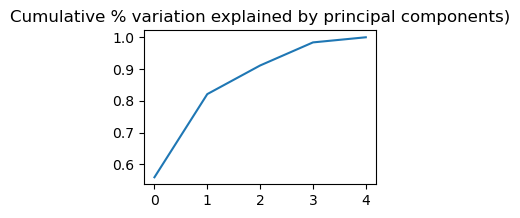

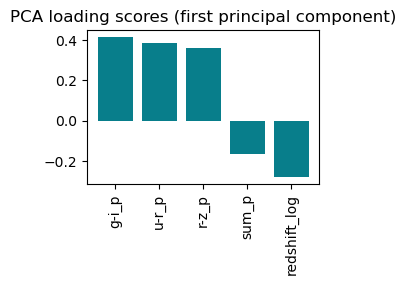

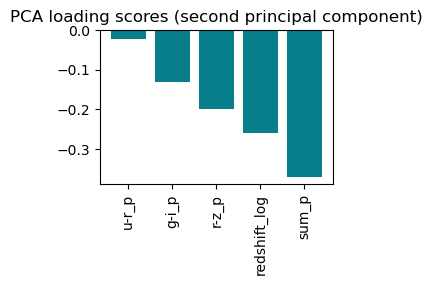


-----X_pca_examples-----


/tmp/ipykernel_22164/1759950996.py:32: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(class_data['PC1'], class_data['PC2'], label=f'Class {label_name}', cmap='viridis', s=1, alpha=0.5)


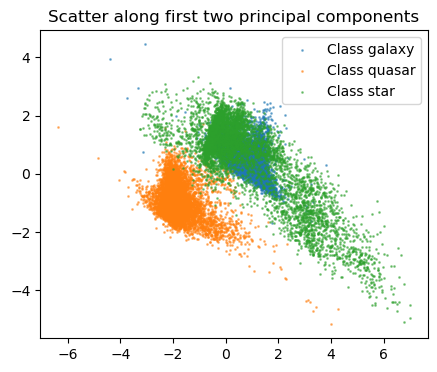

/tmp/ipykernel_22164/1759950996.py:43: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  fig.scatter(class_data['PC3'], class_data['PC2'], class_data['PC1'], label=f'Class {label_name}', cmap='viridis', s=3, alpha=0.4)


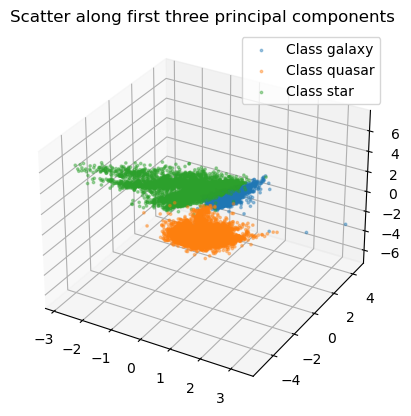

'print(X_pca_examples.shape)\ndisplay(X_pca_examples.head(5))'

In [24]:
# fiting all object_features to a model -- PCA

# setup principal component model
pc = PCA(n_components=3)

# decompose data into principal components (return as ndarrays)
model_pc, history_pc = jsm_fit_model(pc, objects, X0_train, y_train, None, None, 'save')
X7_train = model_pc.transform(X0_train)
X7_validation = model_pc.transform(X0_validation)
X7_test = model_pc.transform(X0_test)
print(X7_train.shape)
print(X7_train[0:5,0:5])

# evaluate principal component explained variance and feature loadings
X_pca_loadings = pca_features(X0_train, features)
"""print(X_pca_loadings.shape)
display(X_pca_loadings.head(5))"""

# plot first two principal components to observe underlying structure
print('\n-----X_pca_examples-----')
X_pca_examples = pca_examples(X7_train, y_train, class_column, label_map)
"""print(X_pca_examples.shape)
display(X_pca_examples.head(5))"""

# Investigate Models for Tabular Data

In [ ]:
# empty block to enable hyperparameter tuning

### model_slr: Simple Linear Regression

In [24]:
from sklearn import linear_model
from sklearn.metrics import r2_score
import matplotlib.cm as cm

if objects == 'stars':

    # un-transform the feature dataset
    #X0_train_untransformed = scaler0.inverse_transform(X0_train)

    # define the dependent variable of interest
    star_y_variable = 'elodie_temperature'
    star_y_idx = X_train.columns.get_loc(star_y_variable)
    star_y_train = X0_train[:, star_y_idx] # not untransformed
    star_y_validation = X0_validation[:, star_y_idx] # not untransformed
    star_y_test = X0_test[:, star_y_idx] # not untransformed

    # define the independent variables of interest
    star_x_variables = ['elodie_color_index'] #['sum_p'] #['sum_p', 'u-r_p', 'g-i_p', 'r-z_p']
    star_x_idx = [X_train.columns.get_loc(star_x_variable) for star_x_variable in star_x_variables]
    star_x_train = X0_train[:, star_x_idx] + 1 # not untransformed
    star_x_validation = X0_validation[:, star_x_idx] + 1 # not untransformed
    star_x_test = X0_test[:, star_x_idx] + 1 #  not untransformed

    mode = 'log-level' # default should always be level-level
    if mode == 'log-log':
        star_y_train = np.log(star_y_train + 1)
        star_y_test = np.log(star_y_test + 1)
        star_y_validation = np.log(star_y_validation + 1)
    elif mode == 'log-level':
        star_x_train = np.log(star_x_train + 1)
        star_x_test = np.log(star_x_test + 1)
        star_x_validation = np.log(star_x_validation + 1)
    elif mode == 'log-log':
        star_x_train = np.log(star_x_train + 1)
        star_x_test = np.log(star_x_test + 1)
        star_x_validation = np.log(star_x_validation + 1)
        star_y_train = np.log(star_y_train + 1)
        star_y_test = np.log(star_y_test + 1)
        star_y_validation = np.log(star_y_validation + 1)

    # setup linear regression
    slr = linear_model.LinearRegression()

    # fit lienar regression model
    model_slr, history_slr = jsm_fit_model(slr, objects, star_x_train, star_y_train, star_x_validation, star_y_validation, mode='save')
    model_slr = slr.fit(star_x_train, star_y_train)

    # compute model parameters and coefficient of determination for train data
    print(f"{model_slr.intercept_ = }")
    print(f"{model_slr.coef_ = }")
    print(f"Train R-squared = {model_slr.score(star_x_train, star_y_train)}")
    
    # compute coefficient of determination for the test data
    star_y_test_pred = model_slr.predict(star_x_test)
    print(f"Test R-squared = {model_slr.score(star_x_test, star_y_test)}")

    # plot the train dataset and model
    scatter = plt.scatter(star_x_train[:,0], star_y_train, c=y_train['stellar_subclass_code'], cmap=cm.rainbow)
    legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.to_rgba(code)) for code in label_codes]
    desired_label_order = [0,1,2,3,4]
    legend_labels = [label_map[code] for code in desired_label_order]
    plt.legend(legend_handles, legend_labels, title='Stellar MK Subclasses')
    plt.title('Relationship between Elodie CI and Temperature')
    plt.xlabel('Log Elodie Color Index')
    plt.ylabel('Log of Log Temperature (K)')
    plt.plot(star_x_train, model_slr.predict(star_x_train), color='black', linewidth=1)
    equation = f"Equation: y = {model_slr.coef_[0]:.2f} * x + {model_slr.intercept_:.2f}"
    plt.text(min(star_x_train), min(star_y_train), equation, verticalalignment='bottom', horizontalalignment='left')
    plt.show()


### model_km: k-means Clustering

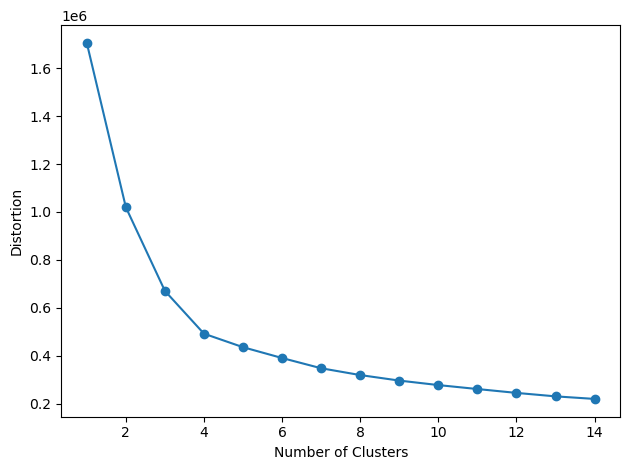


	TRAIN SUBSET:
{'Accuracy Score': 0.2454, 'Precision Score': 0.1463, 'Recall Score': 0.2454, 'F1 Score': 0.1799}
              precision    recall  f1-score   support

      galaxy       0.00      0.00      0.00    113648
      quasar       0.02      0.00      0.01    113648
        star       0.42      0.73      0.53    113648

    accuracy                           0.25    340944
   macro avg       0.15      0.25      0.18    340944
weighted avg       0.15      0.25      0.18    340944



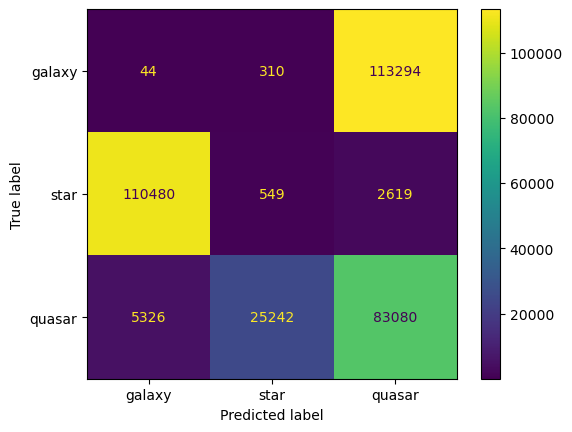


	VALIDATION SUBSET:
{'Accuracy Score': 0.2508, 'Precision Score': 0.1175, 'Recall Score': 0.2508, 'F1 Score': 0.1589}
              precision    recall  f1-score   support

      galaxy       0.00      0.00      0.00    105892
      quasar       0.01      0.01      0.01     37962
        star       0.34      0.74      0.46     74001

    accuracy                           0.25    217855
   macro avg       0.12      0.25      0.16    217855
weighted avg       0.12      0.25      0.16    217855



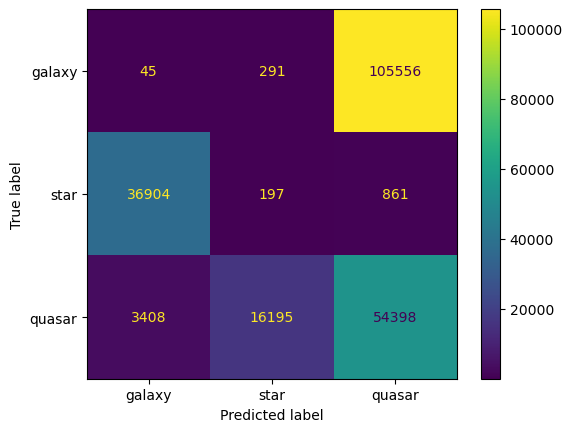

'# make predictions using a model, print performance metrics, then generate a confusion matrix\nprint(f"\n\tVALIDATION SUBSET:")\njsm_predict(model_km, X7_test, y_test)'

In [25]:
# model as k-means clusters

# evaluate elbow plot of cluster numer
kmeans_elbow(X0_train)

# setup k-means model w/ number of clusters equal to number of known labels
km = KMeans(
    n_clusters=y_train.nunique()[0],
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=1e-04,
    random_state=38
    )

# fit k-means model
model_km, history_km = jsm_fit_model(km, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_km, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_km, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_km, X7_test, y_test)"""

### model_knn: K Nearest Neighbors Classifier

In [ ]:
# model as a k nearest neighbors classifier

# setup random forest model
knn = KNeighborsClassifier(n_neighbors=100)

# fit random forest classifier
model_knn, history_knn = jsm_fit_model(knn, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_knn, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_knn, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_knn, X0_test, y_test)"""

### model_mlrc: Multiclass Logistic Regression Classifier

In [ ]:
# model as a multiclass logistic regression classifier

# setup multiclass logistic regression model
mlrc = LogisticRegression(solver='lbfgs', penalty='l2', C=10, l1_ratio=None, max_iter=50, tol=1e-4, multi_class='ovr', class_weight='balanced')

# fit multiclass logistic regression classifier
model_mlrc, history_mlrc = jsm_fit_model(mlrc, objects, X0_train, y_train, None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_mlrc, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlrc, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlrc, X0_test, y_test)"""

### model_svc:  Support Vector Machine

In [ ]:
# model as a support verctor machine classifier

# setup support vector machine model
svc = SVC(C=10, max_iter=100, class_weight='balanced', decision_function_shape='ovr')

# fit msupport verctor machine classifier
model_svc, history_svc = jsm_fit_model(svc, objects, X0_train, y_train, None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_svc, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_svc, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_svc, X0_test, y_test)"""

### model_dt: Decision Tree Classifier

In [ ]:
# model as decision tree classifier
 
# setup decision tree model
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10, max_depth=10)#, class_weight = {}#class_weight={0:1.1, 1:1, 2:1.15}, min_samples_leaf=5, random_state=5)

# fit random forest classifier
model_dt, history_dt = jsm_fit_model(dt, objects, X0_train, y_train, None, None, 'save')
"""dt.fit(X0_train, y_train)"""

# plot decision tree
plt.figure(figsize=(1.25, 1.25), dpi=600)
class_names = sorted(y_train[class_column[0]].unique())
#class_names = [str(value) for value in class_names]
class_names = [label_map[label_code] for label_code in label_map]
tree.plot_tree(model_dt, filled=True, label='none', feature_names=features, class_names=class_names, max_depth=2, proportion=True, impurity=False, precision=1)
#tree.plot_tree(model_dt, filled=True, label='none', feature_names=features, class_names=class_names, max_depth=2, proportion=True, impurity=False, precision=1)
#plt.figure(figsize=(1.25, 1.25), dpi=600)
plt.show()

# make predictions using a model, print performance metrics, then generSate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_dt, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_dt, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_dt, X0_test, y_test)"""

### model_rf:  Random Forest Classifier

In [ ]:
# model as a random forest classifier

# setup random forest model
rf = RandomForestClassifier(criterion='entropy', max_depth=10, bootstrap=True, n_estimators=1000) # max_depth = 3

# fit random forest classifier
model_rf, history_rf = jsm_fit_model(rf, objects, X0_train, y_train.values.ravel(), None, None, 'save')

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_rf, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_rf, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_rf, X0_test, y_test)"""


### model_mlp: Multilayer Perceptron Model

In [ ]:
# model as a multiclass logistic regression classifier
# NOTE: using two hidden layers

# setup multiclass logistic regression model
mlp = keras.Sequential([

    layers.Dense(
        units=512,                                  # output dim
        input_shape=[X_train.shape[1]],             # input dim
        use_bias=True,                              # we included the bias in X
        activation='relu',                          # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    ),

    layers.Dense(
        units=128,                                  # output dim
        use_bias=True,                              # we included the bias in X
        activation='relu',                          # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    ),
    layers.Dense(
        units=y_train.nunique()[0],                 # output dim
        use_bias=True,                              # we included the bias in X
        activation='softmax',                       # apply a sigmoid to the output
        kernel_initializer='random_normal',         # initialize params to small random numbers
        bias_initializer='zeros'                    # initialize biases to 0
    )
])
print(mlp.summary())
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1) # leraning_rate=0.01
mlp.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# fit multiclass logistic regression classifier
model_mlp, history_mlp = jsm_fit_model(mlp, objects, X0_train, y_train, X0_validation, y_validation, 'save', epochs=20, batch_size=2048, verbose=1) # quick training:  epochs=3, batch_size=65536, verbose=1

# plot performance history
jsm_plot_history(history_mlp)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tTRAIN SUBSET:")
jsm_predict(model_mlp, X0_train, y_train)

# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlp, X0_validation, y_validation)

"""# make predictions using a model, print performance metrics, then generate a confusion matrix
print(f"\n\tVALIDATION SUBSET:")
jsm_predict(model_mlp, X0_test, y_test)"""

# Summarization of Results

In [ ]:
# Procedure used for the Summary:
#
# HYPERPARAMETER TUNING:  FOR EACH TASK/MODEL, VARY REBALANCING MODE, VARY X dataset (X0 vs. X7), VARY 2-5 HYPERPARAMETERS W/ 2-5 VALUES...
#                   THEN DOCUMENT METRICS (INCLUDING RUN-TIME)
# FINAL EVALUATION OF TEST SET (ON CHOSEN HYPERPARAMETERS)
#                   if possible, including a histogram of boxplot of metrics based on k-fold validation
# FOR EACH TASK/MODEL, SUMMARIZE METRICS